<a href="https://colab.research.google.com/github/Ephraimosse9/Pytorch-course-on-UDEMY--Notes-and-Codes/blob/main/computer_vision_lecture_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
!pip install torchmetrics
from torchmetrics.classification import Accuracy
from torchmetrics import ConfusionMatrix
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm


#1.   Load the torchvision.datasets.MNIST() train and test datasets.

In [2]:
train_data = datasets.MNIST(
    root= "data",
    train= True,
    download=True,
    transform= ToTensor()
)

test_data = datasets.MNIST(
    root= "data",
    train= False,
    download=True,
    transform= ToTensor()
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

In [5]:
train_data.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [6]:
class_names = train_data.classes

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

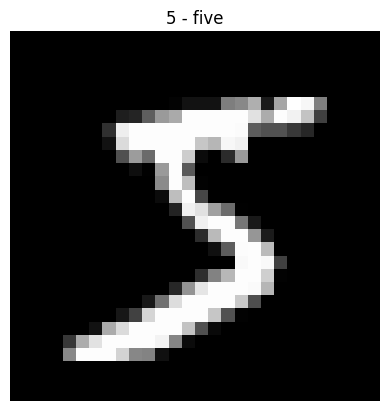

In [7]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

#2.  Visualize at least 5 different samples of the MNIST training dataset.

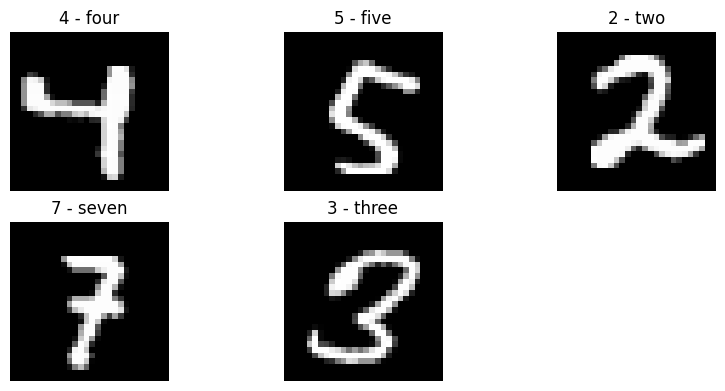

In [8]:
fig = plt.figure(figsize=(10,7))
row, col = 3,3

for i in range(5):
  idx = torch.randint(0, len(train_data), size=[1]).item()
  img, labs = train_data[idx]
  fig.add_subplot(row, col, i+1)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[labs])
  plt.axis(False)

#3.   Turn the MNIST train and test datasets into dataloaders using torch.utils.data.DataLoader, set the batch_size=32.

In [9]:
train_data_loader = DataLoader(
    dataset= train_data,
    batch_size= 32,
    shuffle= True
)

test_data_loader = DataLoader(
    dataset= test_data,
    batch_size= 32,
    shuffle= False
)

In [10]:
len(train_data_loader), len(test_data_loader)

(1875, 313)

#4.   Recreate model_2 used in this notebook (the same model from the CNN Explainer website, also known as TinyVGG) capable of fitting on the MNIST dataset.  

In [11]:
def training_step(model, train_data_loader, loss_fn, optimizer, device, accuracy_fn):
  train_loss, train_acc = 0,0
  for X, y in train_data_loader:
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    accuracy = accuracy_fn(y_pred.argmax(dim=1), y)

    train_loss += loss
    train_acc += accuracy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(train_data_loader)
  train_acc /= len(train_data_loader)

  print(f"Training Loss: {train_loss: .2f} | Training Accuracy: {train_acc*100: .2f}")


In [12]:
def testing_step(model, test_data_loader, loss_fn, device, accuracy_fn):
  test_loss, test_acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X, y in test_data_loader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      accuracy = accuracy_fn(y_pred.argmax(dim=1), y)

      test_loss += loss
      test_acc += accuracy


    test_loss /= len(test_data_loader)
    test_acc /= len(test_data_loader)

  print(f"Testing Loss: {test_loss: .2f} | Testing Accuracy: {test_acc*100: .2f}")

In [13]:
torch.cuda.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
class MNISTmodel(nn.Module):
  def __init__(self, in_channels, hidden_units, output_shape):
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size= 3, stride= 1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size= 3, stride= 1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size= 3, stride= 1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size= 3, stride= 1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= 490, out_features= hidden_units),
        nn.ReLU(),
        nn.Linear(in_features= hidden_units, out_features= output_shape)
    )

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.classifier(x)

    return x

model_0 = MNISTmodel(in_channels=1, hidden_units=10, output_shape= len(class_names)).to(device)

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= model_0.parameters(), lr = 0.1)
accuracy_fn = Accuracy(task="multiclass", num_classes= len(class_names)).to(device)

In [15]:
device

'cuda'

#5.  Train the model you built in exercise 8. on CPU and GPU and see how long it takes on each.

In [16]:
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n")
  training_step(model=model_0, train_data_loader=train_data_loader, loss_fn=loss_fn, optimizer=optimizer, device= device, accuracy_fn=accuracy_fn)
  testing_step(model=model_0, test_data_loader=test_data_loader, loss_fn=loss_fn, device= device, accuracy_fn=accuracy_fn)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0

Training Loss:  0.45 | Training Accuracy:  84.54
Testing Loss:  0.08 | Testing Accuracy:  97.65
Epoch: 1

Training Loss:  0.08 | Training Accuracy:  97.52
Testing Loss:  0.08 | Testing Accuracy:  97.66
Epoch: 2

Training Loss:  0.06 | Training Accuracy:  98.05
Testing Loss:  0.07 | Testing Accuracy:  97.77


#6.   Make predictions using your trained model and visualize at least 5 of them comparing the prediction to the target label.

In [28]:
import random
test_samples = []
test_labels = []

for samples, labels in random.sample(list(test_data), k=9):
  test_samples.append(samples)
  test_labels.append(labels)

predictions = []
model_0.eval()
with torch.inference_mode():
  for samples in test_samples:
    y_pred = model_0(samples.unsqueeze(dim=0).to(device))
    y_pred_probs = y_pred.argmax(dim=1)
    predictions.append(y_pred_probs.cpu())

predictions = torch.cat(predictions).to(device)
predictions

tensor([3, 9, 9, 3, 5, 8, 3, 6, 1], device='cuda:0')

In [29]:
test_labels

[3, 9, 4, 3, 5, 8, 3, 6, 1]

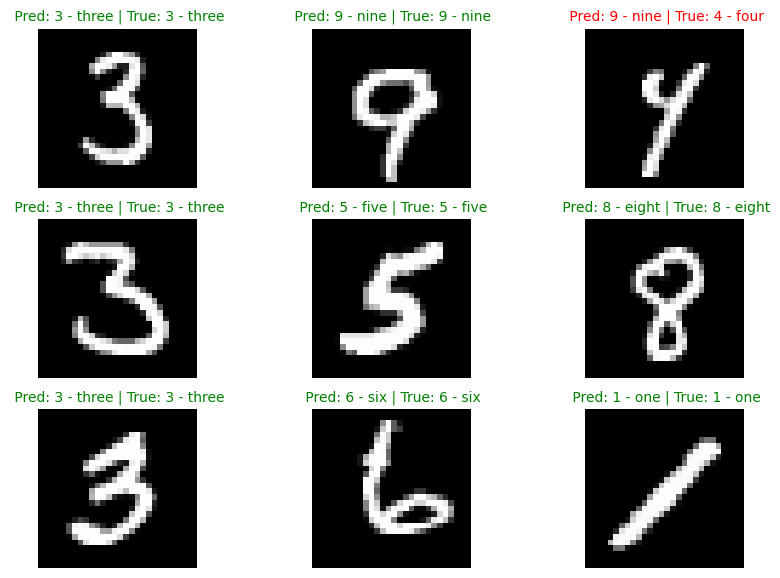

In [30]:
fig = plt.figure(figsize=(10,7))
row,col = 3,3
for i, sample in enumerate(test_samples):
  fig.add_subplot(row, col, i+1)
  plt.imshow(sample.squeeze(), cmap= "gray")
  pred_value = predictions[i]
  true_value = test_labels[i]

  title = f" Pred: {class_names[pred_value]} | True: {class_names[true_value]}"

  if pred_value == true_value:
    plt.title(title, fontsize=10, c="g")
  else:
    plt.title(title, fontsize=10, c="r")
  plt.axis(False)


#7.  Plot a confusion matrix comparing your model's predictions to the truth labels.

In [36]:
y_pred = []
model_0.eval()
with torch.inference_mode():
  for X, y in test_data_loader:
    X = X.to(device)
    pred_logits = model_0(X)
    pred = pred_logits.argmax(dim=1)
    y_pred.append(pred.cpu())
y_pred = torch.cat(y_pred).to(device)

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

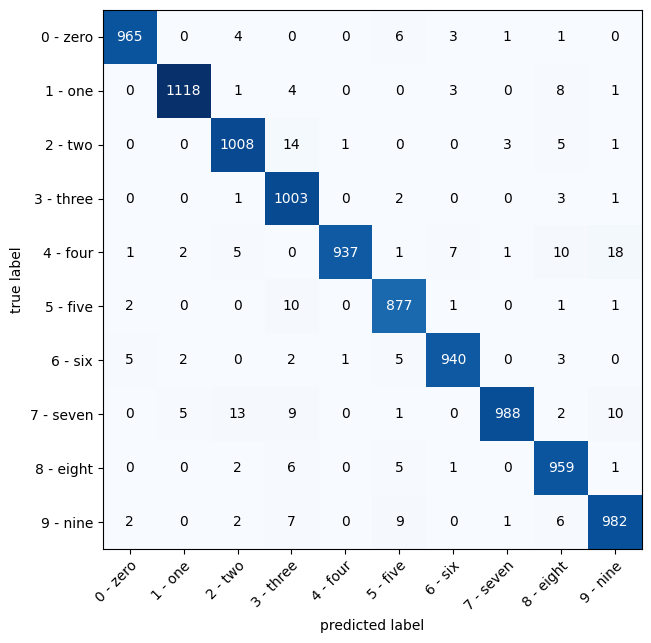

In [40]:
confusion_mat = ConfusionMatrix(task="multiclass", num_classes=len(class_names)).to(device)
conf_mat = confusion_mat(y_pred, test_data.targets.to(device))

plot_confusion_matrix(conf_mat=conf_mat.cpu().numpy(), figsize=(10,7), class_names=class_names )